# Decision tree classification - Human resources
## In this project I will use synthetic human resources data from kaggle.com to assess and classify employees that are at risk of termination or leaving their job. Understanding employee churn can help reduce employee turnover, improve productivity and maintain a stable work environment.
## I will explain the importance of **One hot encoding** and **pruning a decision tree**.
## Using the results of the decision tree, I will provide solutions/recommendations for employee retention.
### For results and recommendation, skip to section 4 and 5.
### **1. Importing libraries and loading data**

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [82]:
hr = pd.read_csv('HRDataset.csv')
hr.sample(3)

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,...,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30
229,"Trzeciak, Cybil",1107027551,0,0,0,5,5,3,0,22.00,...,Production,Amy Dunn,11.0,Vendor Referral,Fully Meets,1.30,3,0,NaN,NaN
119,"Brill, Donna",1406068293,1,1,0,5,5,3,0,20.00,...,Production,David Stanley,14.0,Search Engine - Google Bing Yahoo,Fully Meets,3.35,4,0,NaN,NaN
196,"Crimmings, Jean",1311063172,0,0,0,2,5,3,0,19.75,...,Production,Michael Albert,22.0,Newspager/Magazine,Fully Meets,4.12,5,0,1/28/2019,0.0


In [83]:
hr.shape

(310, 35)

### This dataset contains information on 310 employees and 35 features.
### **2. Exploratory analysis, feature selection and pre-processing**

In [84]:
hr.columns

Index(['Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'GenderID',
       'EmpStatusID', 'DeptID', 'PerfScoreID', 'FromDiversityJobFairID',
       'PayRate', 'Termd', 'PositionID', 'Position', 'State', 'Zip', 'DOB',
       'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc',
       'DateofHire', 'DateofTermination', 'TermReason', 'EmploymentStatus',
       'Department', 'ManagerName', 'ManagerID', 'RecruitmentSource',
       'PerformanceScore', 'EngagementSurvey', 'EmpSatisfaction',
       'SpecialProjectsCount', 'LastPerformanceReview_Date', 'DaysLateLast30'],
      dtype='object')

<Axes: xlabel='count', ylabel='TermReason'>

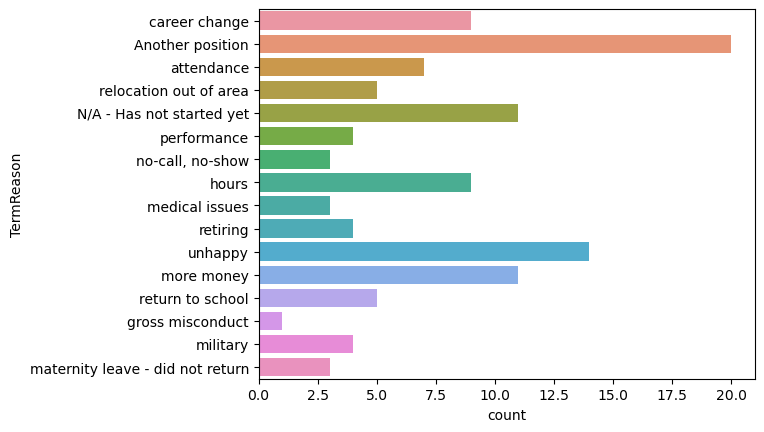

In [85]:
# Reason for termination excluding employees that are still employed
hr['TermReason'].value_counts()
sns.countplot(y = hr[hr['TermReason'] != 'N/A - still employed']['TermReason'].sort_index(), data= hr)

### Looking at the reasons employees resign or get terminated, we observe that getting a different offer, unhappiness, seeking higher compensation and lesser hours are key contributors. This gives a good starting point in understanding employee churn.
### We will further investigate with the decision tree for early indicators of termination or resignation.

In [87]:
print('Departments:', hr['Department'].unique())
print(' ')
print(hr['Department'].nunique(), 'Departments')

Departments: ['Admin Offices' 'Sales' 'IT/IS' 'Production       ' 'Executive Office'
 'Software Engineering']
 
6 Departments


### The organization consists of 6 departments, Admin Offices, Sales, IT/IS, Production, Executive Office and Software Engineering.
### For this analysis, we will use the Termd (whether an employee has been terminated or resigned, or is retained) as the target and use marital status, employee performance, method of sourcing (FromDiversityJobFairID), pay rate, employee satisfaction, the number of special projects an employee worked on and the department an employee falls under as the features.

In [86]:
hr1 = hr[['Termd', 'MarriedID', 'PerfScoreID', 'FromDiversityJobFairID', 'PayRate',
 'EmpSatisfaction', 'SpecialProjectsCount', 'DeptID']]
print('Null values =', hr1.isna().sum().sum())

Null values = 0


### Next I will perform **one hot encoding** on nominal (unordered) categorical data. In this case we only need to perform this process on the department ID predictor. This is to ensure that the model does not confuse any department as being more important than another. Eg. if Sales has an ID of 1 and Admin has an ID of 3, Admin is not higher or more important than Sales. This confusion can cause inaccurate results.
### One hot encoding creates a feature for each department and assigns binary encoding for each department (see example below). 
### Ordinal (ordered) predictors like employee performance and satisfaction does not need to be converted, in this case 5 is maintained as being higher than 1. 

In [113]:
# One Hot Coding using the get dummies function
hr1_ohe = pd.get_dummies(hr1, columns= ['DeptID'], prefix= 'DeptID')
hr1_ohe
print(hr1_ohe.columns)
hr1_ohe.sample(5)

Index(['Termd', 'MarriedID', 'PerfScoreID', 'FromDiversityJobFairID',
       'PayRate', 'EmpSatisfaction', 'SpecialProjectsCount', 'DeptID_1',
       'DeptID_2', 'DeptID_3', 'DeptID_4', 'DeptID_5', 'DeptID_6'],
      dtype='object')


,Termd,MarriedID,PerfScoreID,FromDiversityJobFairID,PayRate,EmpSatisfaction,SpecialProjectsCount,DeptID_1,DeptID_2,DeptID_3,DeptID_4,DeptID_5,DeptID_6
35,0,1,3,0,45.0,3,6,0,0,1,0,0,0
192,1,0,4,0,19.0,5,0,0,0,0,0,1,0
56,0,0,3,0,62.0,5,7,0,0,1,0,0,0
126,0,1,3,0,20.0,4,0,0,0,0,0,1,0
3,1,1,3,0,21.5,3,4,1,0,0,0,0,0


### As seen, 6 features has been added each representing a different department and assigned 0 otherwise.

In [89]:
X = hr1_ohe.drop(columns= 'Termd')
y = hr1_ohe['Termd']
X.head(0)

,MarriedID,PerfScoreID,FromDiversityJobFairID,PayRate,EmpSatisfaction,SpecialProjectsCount,DeptID_1,DeptID_2,DeptID_3,DeptID_4,DeptID_5,DeptID_6


### **3. Decision tree classification and pruning**
### I will first split the data into a training set and test set using the train_test_split function. 
### Once the data has been split, I will fit a decision tree classifier and assess its performance on unseen data.

Data split: (232, 12) (78, 12)


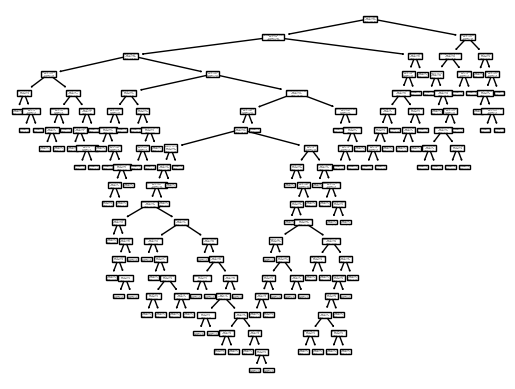

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 0 )
print('Data split:', X_train.shape, X_test.shape)

classifier = DecisionTreeClassifier(random_state= 0)
classifier = classifier.fit(X_train, y_train)

plt.Figure()
plot_tree(classifier, feature_names= X.columns.tolist())
plt.show()

In [116]:
# Testing on unseen data for accuracy score
y_pred = classifier.predict(X_test)
test_score = accuracy_score(y_test, y_pred)
print('Accuracy score: {:2.2%}'.format(test_score))
print('Tree depth:', classifier.get_depth())
print('Number of leaves:', classifier.get_n_leaves())

Accuracy score: 58.97%
Tree depth: 19
Number of leaves: 95


### Our initial model has an accuracy score of 58.97% with the tree containing 19 levels and 95 nodes.
### Next I will prune the decision tree. Pruning is a technique used to simplify and improve the performance of a decision tree. This is done by reducing branches that do not contribute to the accuracy of the tree.
### In order to prune the tree, I will use cross validation to find the optimal samples per leaf. This will be done by comparing the validation score of a range of samples per leaf.

In [93]:
# Finding the optimal number of samples
samples = [sample for sample in range(1, 30)] # range of 30 to ensure that we do not have more than 10% per leaf
val_score = []
for sample in samples:
    classifier2 = DecisionTreeClassifier(random_state= 1, min_samples_leaf= sample)
    score = cross_val_score(estimator= classifier2, X= X_train, y= y_train, cv= 5)
    val_score.append(score.mean())

Text(0, 0.5, 'validation score')

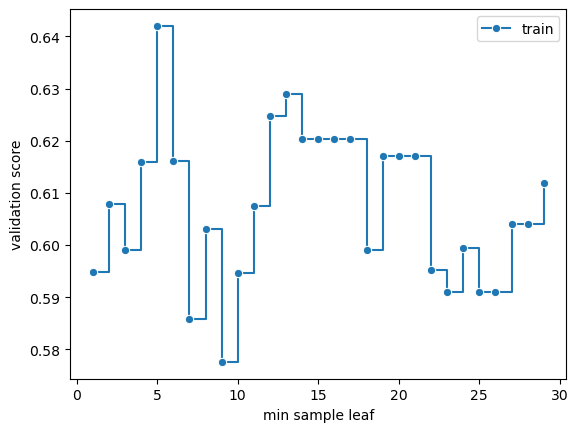

In [94]:
# Visual representation of scores per leaf samples
plt.figure()
sns.lineplot(x= samples, y= val_score, marker= 'o', label= 'train', drawstyle= 'steps-post')
plt.xlabel('min sample leaf')
plt.ylabel('validation score')

In [95]:
optimum_samples = samples[val_score.index(max(val_score))]
optimum_samples

5

### As seen by the visual representation, the optimal samples per leaf is 5. This means each leaf in the decision tree should contain atleast 5 samples.
### Using this number, I will retrain my decision tree classifier and check if this improves the accuracy of the model.

In [119]:
opt_classifier = DecisionTreeClassifier(random_state= 0, min_samples_leaf= 5)
opt_classifier = opt_classifier.fit(X_train, y_train)

opt_y_pred = opt_classifier.predict(X_test)
opt_test_score = accuracy_score(y_test, opt_y_pred)
print('Accuracy score: {:2.2%}'.format(opt_test_score))
print('Tree depth:', opt_classifier.get_depth())
print('Number of leaves:', opt_classifier.get_n_leaves())

Accuracy score: 65.38%
Tree depth: 13
Number of leaves: 34


### Pruning does indeed improve our model. The accuracy increased from 58.87 to 65.38, the number of levels decreased to 13 and we have only 34 leaves instead of 95. This reduces the complexities of interpreting the decision tree and offer more valuable insights.
### It is important to note that a higher min sample leaf can improve accuracy but can lead to overfitting and make the results less reliable, hence using cross validation to determine the optimal number.
### Next will reduce the tree to the first 4 levels, interpret the results and make recommendations for employee retention.

[Text(0.68125, 0.9166666666666666, 'PayRate <= 50.75\nsamples = 232\nvalue = [151, 81]\nclass = not terminated'),
 Text(0.4625, 0.75, 'FromDiversityJobFairID <= 0.5\nsamples = 183\nvalue = [110, 73]\nclass = not terminated'),
 Text(0.275, 0.5833333333333334, 'PerfScoreID <= 2.5\nsamples = 166\nvalue = [104, 62]\nclass = not terminated'),
 Text(0.1, 0.4166666666666667, 'PayRate <= 19.25\nsamples = 18\nvalue = [7, 11]\nclass = terminated'),
 Text(0.05, 0.25, 'samples = 6\nvalue = [1, 5]\nclass = terminated'),
 Text(0.15, 0.25, 'PayRate <= 23.0\nsamples = 12\nvalue = [6, 6]\nclass = not terminated'),
 Text(0.1, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.2, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.45, 0.4166666666666667, 'PayRate <= 17.5\nsamples = 148\nvalue = [97, 51]\nclass = not terminated'),
 Text(0.35, 0.25, 'PayRate <= 15.625\nsamples = 27\nvalue = [22, 5]\nclass = not terminated'),
 Text(0.3, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.4, 0.08333333333333333, '\n  (...

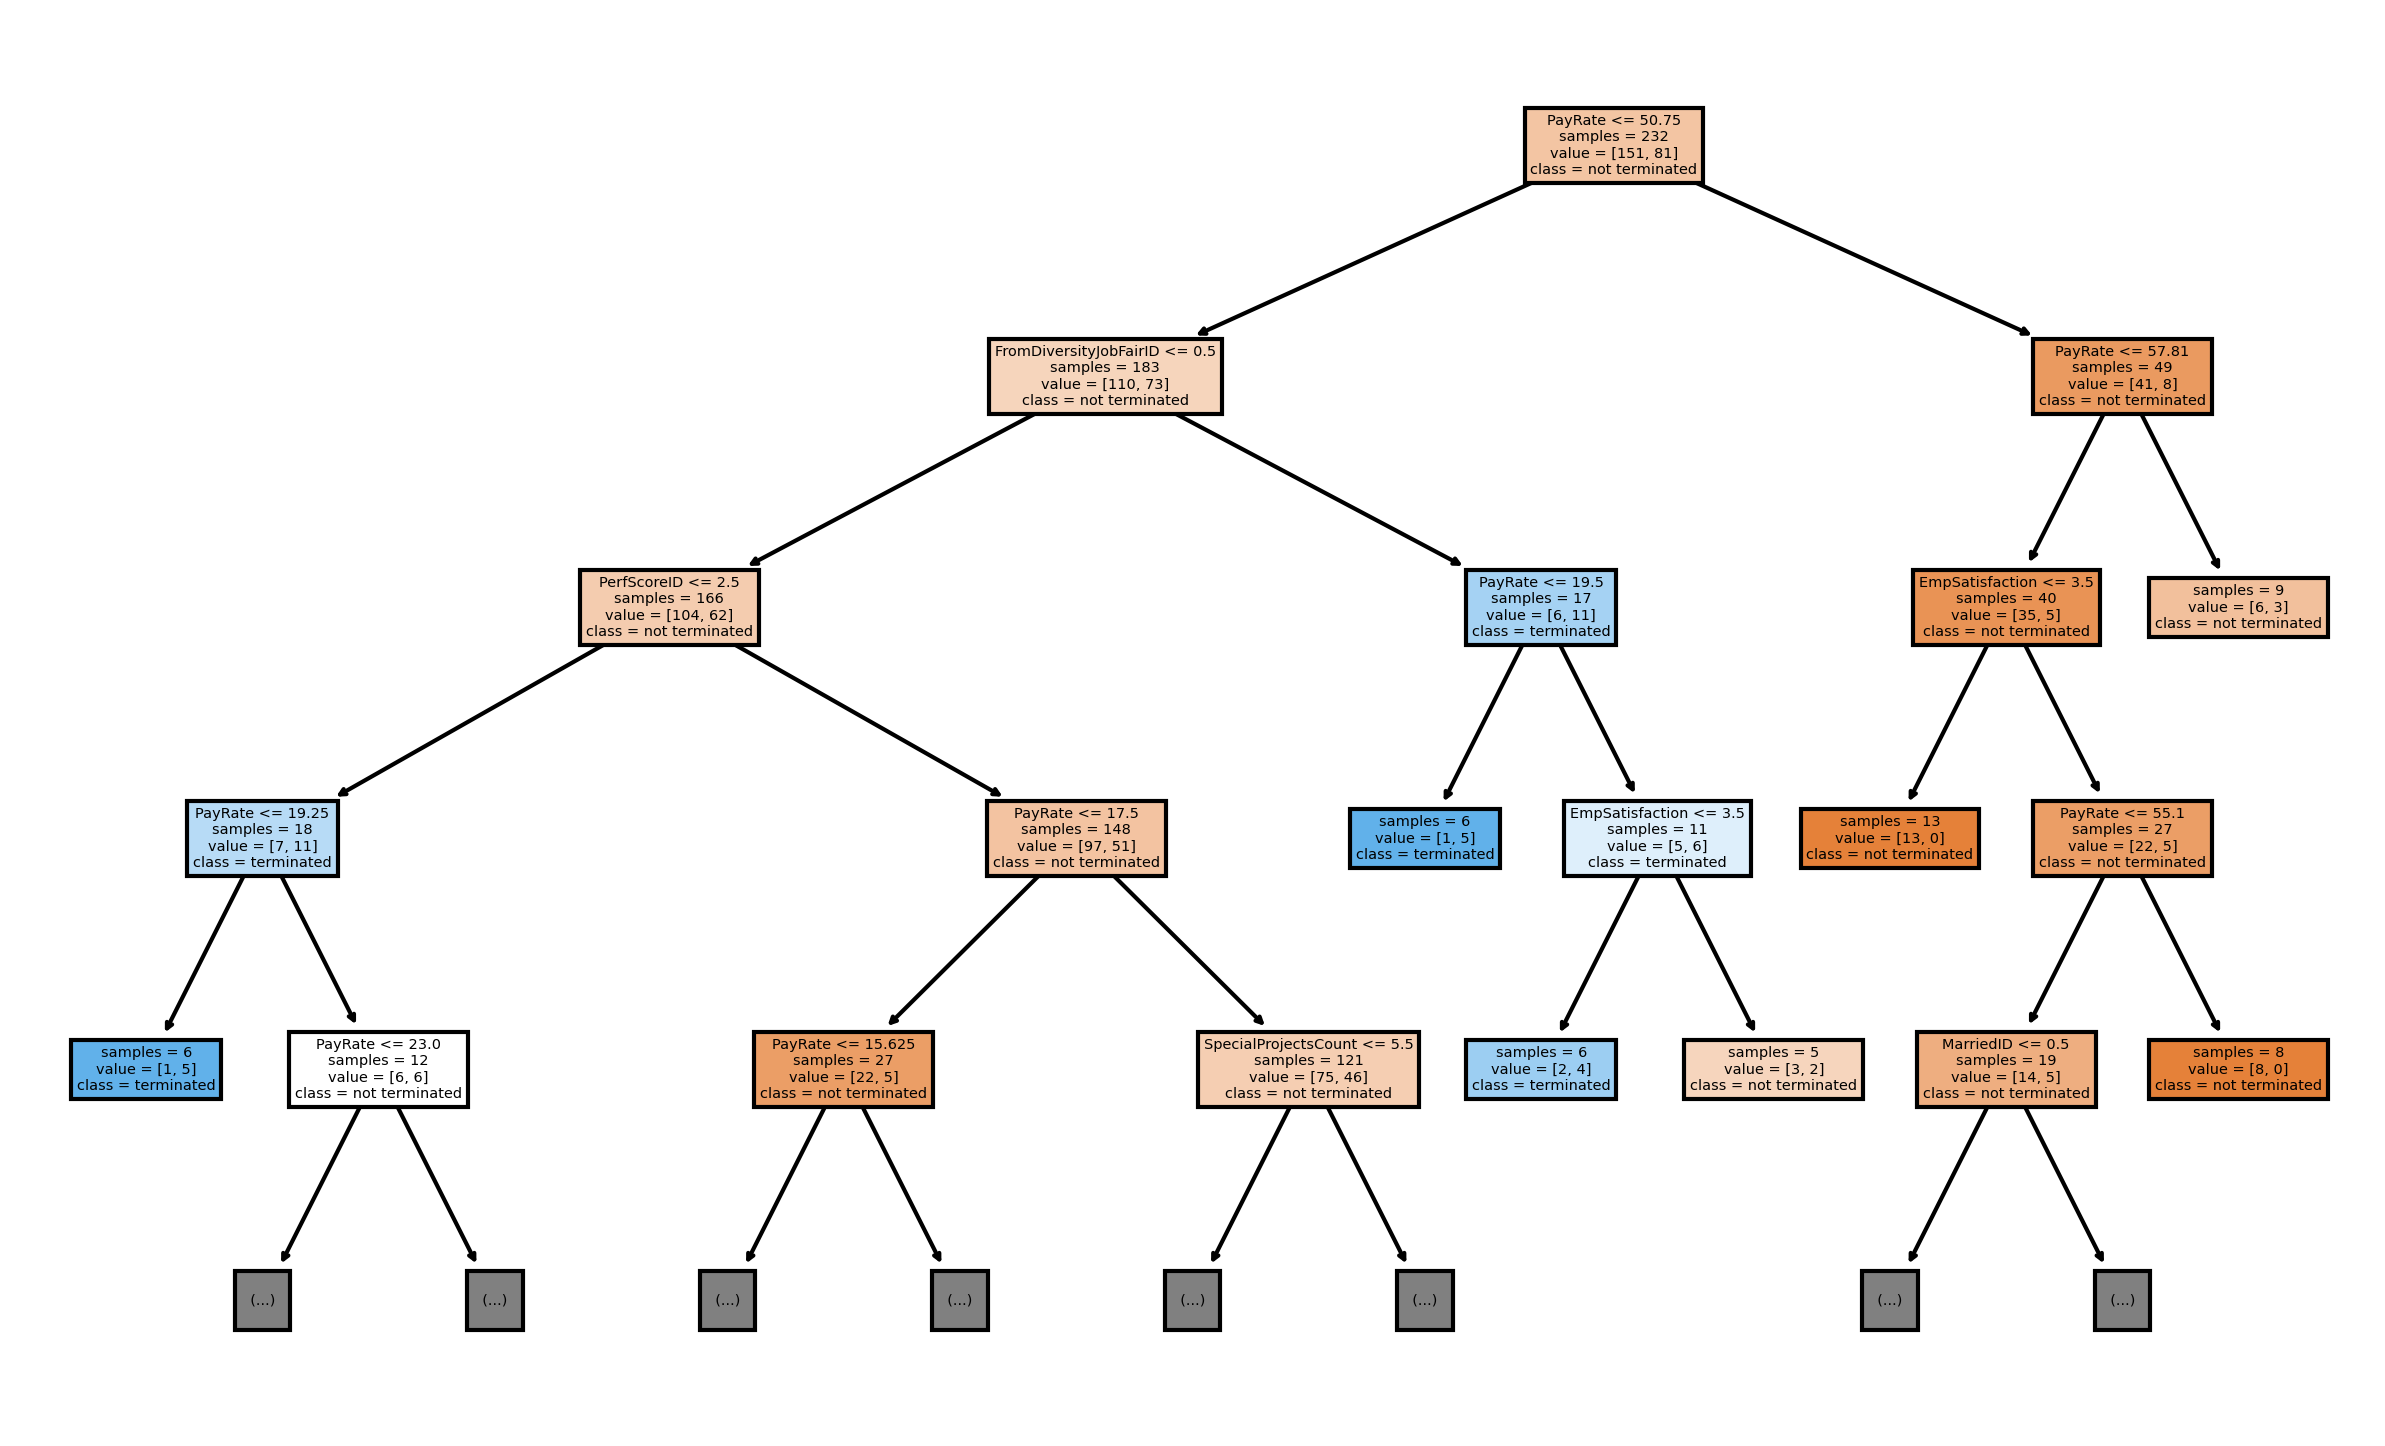

In [121]:
plt.figure(figsize= (10,6), dpi= 300)
plot_tree(opt_classifier, max_depth= 4, feature_names= X.columns.tolist(), class_names= ['not terminated', 'terminated'], impurity= False, filled= True)

### **4. Results of the tree**
### Using the first few levels of the pruned decision tree, we start at the root node split using the pay rate. This implies that employee compensation is the key factor in determining whether an employee will get terminated or resign. It appears that those in the pay rate bracket of 50.75 and lower are more likely to be retained.
### We also note that employees sourced from diversity job fairs are more likely to be terminated or resign. 
### Employee performance is another indicator that can determine the risk of termination. Those that perform badly are more likely to be terminated or resign.
### While employee satisfaction is factored, it plays a secondary role using the upper layers of the tree.
### **5. Recommendation for employee retention**
### Using the pruned decision tree, possible retention strategies include ensuring fair compensation matching industry standards. Feeling underpaid can increase workplace stress and leads to an employee seeking higher compensation and changing roles (either internally or externally). 
### Another way for this organization to reduce employee churn is to avoid sourcing from diversity job fairs and focus more on seeking individuals that are in alignment with the organizational culture.
### Initiatives should be taken to ensure continuous development and upskilling to keep employees motivated and improve their performance. This improves productivity and creates a more efficient organization.
### For the higher earning individuals, it seems that finding ways to improve job satisfication will be beneficial for the organization. High earners are usually highly skilled or possess legacy knowledge making them valuable to retain.